# Calculate the mean of a distribution from its histogram

Patricia Schuster  
2/21/18  

I am doing this because in the fission project, I want to calculate the average energy within an energy distribution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
import sys
sys.path.append('../scripts/')
import bicorr as bicorr
import bicorr_plot as bicorr_plot
import bicorr_math as bicorr_math

In [3]:
%load_ext autoreload
%autoreload 2

# Method for making a step plot

In [7]:
import inspect
print(inspect.getsource(bicorr_plot.step_plot))

def step_plot(edges,y, linewidth=.5, color='k', zorder = 1):
    """
    Plot a step plot. Meant for use with histogram data generated by:
        counts, bin_edges = np.histogram(x_samples,bin_edges)
        bicorr.step_plot(bin_edges,counts)
    
    Parameters
    ----------
    edges : ndarray
        Bin edges
    y : ndarray
        Bin counts
    linewidth : float, optional
        Width of step lines
    color : float, optional
        Color of lines
    zorder : int, optional
        Order of layer. Lower integer = farther back

    Returns
    -------
    n/a
    """
    # Horizontal lines
    for i in range(len(y)):
        plt.hlines(y[i],edges[i],edges[i+1],linewidth=linewidth,color=color,zorder=zorder)
    # Vertical lines
    for i in range(len(y)-1):
        plt.vlines(edges[i+1],y[i],y[i+1],linewidth=linewidth,color=color,zorder=zorder)



# Generate some random data to work with

Using Normal-distributed data

In [8]:
x_samples = np.random.normal(0,5,150)

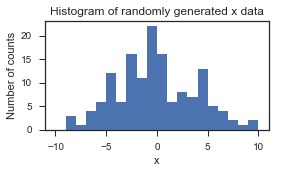

In [9]:
plt.figure(figsize=(4,2))
plt.hist(x_samples,np.arange(-10,10.1,1))
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.title('Histogram of randomly generated x data')
plt.show()

Store histogram data

In [10]:
counts, bin_edges = np.histogram(x_samples,np.arange(-10,10.1,1))

In [11]:
print(bin_edges.shape)
print(counts.shape)

(21,)
(20,)


In [12]:
bin_edges

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [13]:
counts

array([ 0,  3,  1,  4,  6, 12,  6, 16, 11, 22, 16,  6,  8,  7, 13,  5,  4,
        2,  1,  2], dtype=int64)

Look at it using my step plot function.

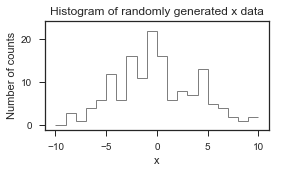

In [16]:
plt.figure(figsize=(4,2))
bicorr_plot.step_plot(bin_edges,counts)
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()

# Calculate mean and associated error

Calculate the average x value for a distribution where we have $C$ counts for each $x$ value. Assume there is no error in $x_i$.

$x_{ave} = \frac{\Sigma(x_i \cdot C_i)}{\Sigma C_i}$

I am going to split this up into the numerator and the denomenator in order to propagate the error. 

$num = \Sigma(x_i \cdot C_i)$

$denom = \Sigma C_i$

## Numerator: $\Sigma(x_i\cdot C_i)$

Think of this as the sum of many products:

$num = x_1 c_1 + x_2 c_2 + ... = a + b + ...$

The error in each quantity is:

$\sigma_{x_i c_i} = x_i \sqrt{c_i}$

The error in the sum of these quantities is:

$\sigma_{num} = \sigma_{a+b+...} = \sqrt{\sigma_a^2+\sigma_b^2+...} = \sqrt{x_1^2 c_1 + x_2^2 c_2 + ...}$

## Denomenator: $\Sigma(C_i)$

This one is more straight forward. The error in the sum of many count quantities is the square root of the total number of counts.

$denom = c_1 + c_2 + ...$

$\sigma_{denom} = \sqrt{\sigma_{c_1}^2+\sigma_{c_2}^2...} = \sqrt{c_1 + c_2 + ...} = \sqrt{c_{sum}} = \sqrt{denom}$

## Put it together

$x_{ave} = \frac{num}{denom} = \frac{\Sigma(x_i \cdot C_i)}{\Sigma C_i}$

$\sigma_{x_{ave}} = x_{ave} \sqrt{(\frac{\sigma_{num}}{num})^2+(\frac{\sigma_{denom}}{denom})^2}$

## Functionalize it

In [34]:
def calc_mean(bin_edges, counts, print_flag = False):
    """
    Calculate mean of a count rate distribution, counts vs. x. 
    Errors are calculated under the assumption that you are working
        with counting statistics. (C_err = sqrt(C) in each bin)
    
    Parameters
    ----------
    bin_edges : ndarray
        Bin edges for x
    counts : ndarray
        Bin counts
    print_flag : bool
        Option to print intermediate values
    
    Returns
    -------
    x_mean : float
    x_mean_err : float
    """
    bin_centers = bicorr.centers(bin_edges)
    
    num = np.sum(np.multiply(bin_centers,counts))  
    num_err = np.sqrt(np.sum(np.multiply(bin_centers**2,counts)))
    denom = np.sum(counts)    
    denom_err = np.sqrt(denom)    

    if print_flag:
        print('num: ',num)
        print('num_err: ',num_err)
        print('denom: ',denom)
        print('denom_err: ',denom_err)
    
    x_mean = num/denom
    x_mean_err = x_mean * np.sqrt((num_err/num)**2+(denom_err/denom)**2)
    
    if print_flag:
        print('x_mean: ',x_mean)
        print('x_mean_err:',x_mean_err)
    
    return x_mean, x_mean_err

In [35]:
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

num:  80.0
num_err:  50.4479930225
denom:  140
denom_err:  11.8321595662
x_mean:  0.571428571429
x_mean_err: 0.36356471266


Plot this and look at the position of the mean.

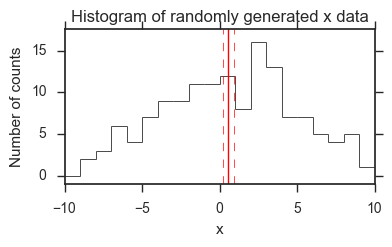

In [42]:
plt.figure(figsize=(4,2))
bicorr.step_plot(bin_edges,counts)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()

Look more closely to make sure it is evenly spaced.

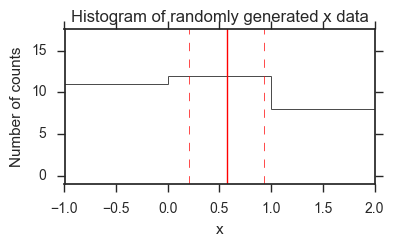

In [44]:
plt.figure(figsize=(4,2))
bicorr.step_plot(bin_edges,counts)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.xlabel('x')
plt.xlim([-1,2])
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Histogram of randomly generated x data')
plt.show()

# Try a few examples to make sure it's working

Only 10 samples... Expect mean to be incorrect and large error bars.

num:  235.0
num_err:  75.5148991921
denom:  10
denom_err:  3.16227766017
x_mean:  23.5
x_mean_err: 10.5948100502


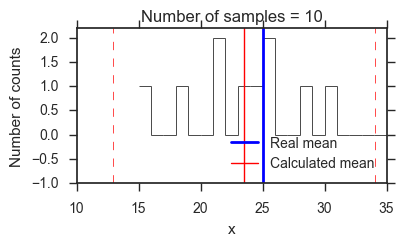

In [62]:
real_mean = 25
real_std = 5
num_samples = 10
x_samples = np.random.normal(real_mean,real_std,num_samples)
counts, bin_edges = np.histogram(x_samples,np.arange(15,35.1,1))
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

plt.figure(figsize=(4,2))
plt.axvline(real_mean,color='b',linewidth=2)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
bicorr.step_plot(bin_edges,counts)
plt.legend(['Real mean','Calculated mean'], loc='lower right')
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Number of samples = {}'.format(num_samples))
plt.show()

Increase the number of samples. Expect mean to be closer, and errors to be smaller.

num:  802.0
num_err:  148.4570645
denom:  30
denom_err:  5.47722557505
x_mean:  26.7333333333
x_mean_err: 6.95059016945


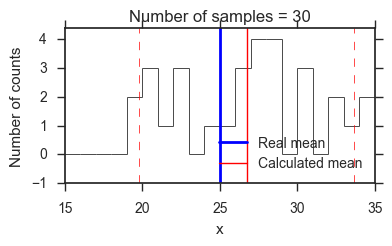

In [65]:
real_mean = 25
real_std = 5
num_samples = 30
x_samples = np.random.normal(real_mean,real_std,num_samples)
counts, bin_edges = np.histogram(x_samples,np.arange(15,35.1,1))
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

plt.figure(figsize=(4,2))
plt.axvline(real_mean,color='b',linewidth=2)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
bicorr.step_plot(bin_edges,counts)
plt.legend(['Real mean','Calculated mean'], loc='lower right')
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Number of samples = {}'.format(num_samples))
plt.show()

num:  2424.0
num_err:  251.443830706
denom:  96
denom_err:  9.79795897113
x_mean:  25.25
x_mean_err: 3.67444133131


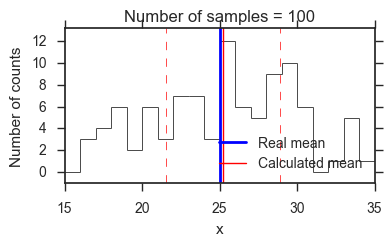

In [66]:
real_mean = 25
real_std = 5
num_samples = 100
x_samples = np.random.normal(real_mean,real_std,num_samples)
counts, bin_edges = np.histogram(x_samples,np.arange(15,35.1,1))
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

plt.figure(figsize=(4,2))
plt.axvline(real_mean,color='b',linewidth=2)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
bicorr.step_plot(bin_edges,counts)
plt.legend(['Real mean','Calculated mean'], loc='lower right')
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Number of samples = {}'.format(num_samples))
plt.show()

num:  23564.0
num_err:  774.904187626
denom:  954
denom_err:  30.886890423
x_mean:  24.7002096436
x_mean_err: 1.13986770074


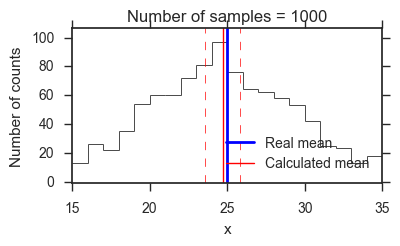

In [67]:
real_mean = 25
real_std = 5
num_samples = 1000
x_samples = np.random.normal(real_mean,real_std,num_samples)
counts, bin_edges = np.histogram(x_samples,np.arange(15,35.1,1))
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

plt.figure(figsize=(4,2))
plt.axvline(real_mean,color='b',linewidth=2)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
bicorr.step_plot(bin_edges,counts)
plt.legend(['Real mean','Calculated mean'], loc='lower right')
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Number of samples = {}'.format(num_samples))
plt.show()

num:  238989.5
num_err:  2483.28789108
denom:  9547
denom_err:  97.7087508875
x_mean:  25.0329422855
x_mean_err: 0.365097808241


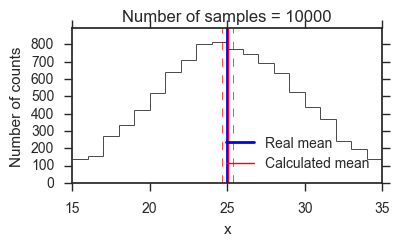

In [68]:
real_mean = 25
real_std = 5
num_samples = 10000
x_samples = np.random.normal(real_mean,real_std,num_samples)
counts, bin_edges = np.histogram(x_samples,np.arange(15,35.1,1))
x_mean, x_mean_err = calc_mean(bin_edges,counts,True)

plt.figure(figsize=(4,2))
plt.axvline(real_mean,color='b',linewidth=2)
plt.axvline(x_mean,color='r',linewidth=1)
plt.axvline(x_mean+x_mean_err,linestyle='--',color='r',linewidth=.5)
plt.axvline(x_mean-x_mean_err,linestyle='--',color='r',linewidth=.5)
bicorr.step_plot(bin_edges,counts)
plt.legend(['Real mean','Calculated mean'], loc='lower right')
plt.xlabel('x')
plt.ylabel('Number of counts')
plt.ylim([-1,1.1*np.max(counts)])
plt.title('Number of samples = {}'.format(num_samples))
plt.show()

I think this looks reasonable. Call it a day.

# In Two Dimensions

If I want to calculate the average sum of $x$ and $y$ across a 2d-histogram, how can I do that?

The equation looks like this:

Calculate the average x value for a distribution where we have $C$ counts for each $x$ value. Assume there is no error in $x_i$ or $y_i$.

$(x+y)_{ave} = \frac{\Sigma((x_i+y_i) \cdot C_i)}{\Sigma C_i}$

I am going to split this up into the numerator and the denomenator in order to propagate the error. 

$num = \Sigma((x_i+y_i) \cdot C_i)$

$denom = \Sigma C_i$

## Numerator: $\Sigma((x_i+y_i)\cdot C_i)$

Think of this as the sum of many products:

$num = x_1 y_1 c_{11} + x_2 y_1 c_{21} + ... = a + b + ...$

The error in each quantity is:

$\sigma_{(x_i+y_i) c_i} = (x_i+y_i) \sqrt{c_i}$

The error in the sum of these quantities is:

$\sigma_{num} = \sigma_{a+b+...} = \sqrt{\sigma_a^2+\sigma_b^2+...} = \sqrt{(x_1+y_1)^2 c_{11} + (x_2+y_1)^2 c_{21} + ...}$

## Denomenator: $\Sigma(C_i)$

This one is more straight forward. The error in the sum of many count quantities is the square root of the total number of counts.

$denom = c_1 + c_2 + ...$

$\sigma_{denom} = \sqrt{\sigma_{c_1}^2+\sigma_{c_2}^2...} = \sqrt{c_1 + c_2 + ...} = \sqrt{c_{sum}} = \sqrt{denom}$

## Put it together

$(x+y)_{ave} = \frac{num}{denom} = \frac{\Sigma((x_i+y_i) \cdot C_i)}{\Sigma C_i}$

$\sigma_{x_{ave}} = x_{ave} \sqrt{(\frac{\sigma_{num}}{num})^2+(\frac{\sigma_{denom}}{denom})^2}$

In [26]:
x_samples = np.random.normal(150,20,150);
y_samples = np.random.normal(75,10,150);
sum_samples = x_samples + y_samples

C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


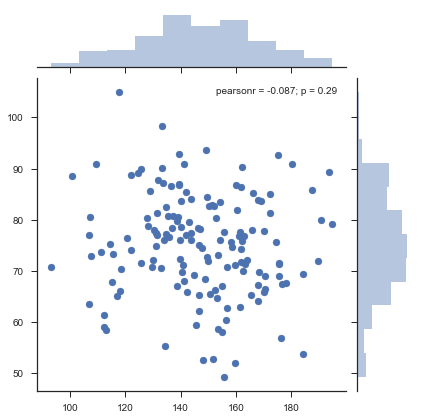

In [27]:
sns.jointplot(x_samples,y_samples)
plt.show()

In [90]:
np.mean(x_samples+y_samples)

222.08635797866148

C:\Users\pfschus\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


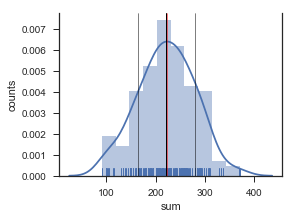

In [23]:
bicorr_plot.histogram_metrics(sum_samples,'sum','counts')

Create a 2d-histogram.

In [47]:
x_edges = np.arange(0,201,10)
y_edges = np.arange(0,111,10)

H, x_edges, y_edges = np.histogram2d(x_samples,y_samples, bins=[x_edges,y_edges])
H = H.T

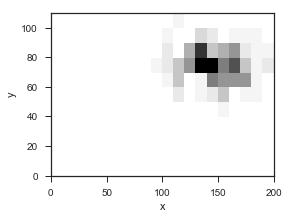

In [48]:
fig = plt.figure(figsize=(4,3))
ax = plt.gca()
mesh = ax.pcolormesh(x_edges, y_edges, H)
plt.xlabel('x'); plt.ylabel('y')
plt.show()

In [49]:
H.shape

(11, 20)

In [36]:
x_edges.shape

(21,)

In [37]:
y_edges.shape

(12,)

In [50]:
X, Y = np.meshgrid(bicorr_math.calc_centers(x_edges),bicorr_math.calc_centers(y_edges))

In [53]:
X.shape

(11, 20)

In [54]:
Y.shape

(11, 20)

In [52]:
H.shape

(11, 20)

In [57]:
X = X.reshape(X.shape[0]*X.shape[1])
Y = Y.reshape(Y.shape[0]*Y.shape[1])
H = H.reshape(H.shape[0]*H.shape[1])

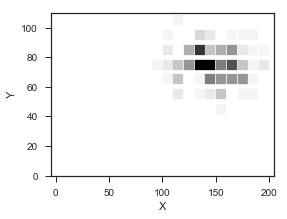

In [82]:
plt.figure(figsize=(4,3))
plt.scatter(X, Y, c=H, marker='s', s=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

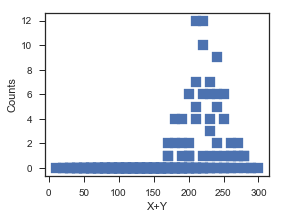

In [87]:
plt.figure(figsize=(4,3))
plt.scatter(X+Y, H, marker='s', s=100)
plt.xlabel('X+Y')
plt.ylabel('Counts')
plt.show()

Now try calculating the average.

In [92]:
bicorr_math.calc_histogram_mean(X+Y,H,True,True)

num:  33330.0
num_err:  2735.5255436570137
denom:  150.0
denom_err:  12.24744871391589
x_mean:  222.2
x_mean_err: 25.724200451887494


(222.2, 25.724200451887494)

This can be used for `bhp` and `bhp_e`.